# Des ODE avec Jax ?

In [1]:
%matplotlib ipympl
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit, vmap
from dataclasses import dataclass
from jax.tree_util import register_dataclass
from diffrax import ODETerm, Dopri5, SaveAt, PIDController, diffeqsolve

jax.config.update("jax_enable_x64", True)

## Problème

On s'intéresse à une paire d'oscillateurs linéaires couplés par une raideur $K_{12}$. 
On voudrait trouver un régime permanent de manière simple, par exemple en simulant quelques périodes d'excitation. 

L'équation différentielle est:

$$
\left \lbrace 
\begin{split}
M_1  \ddot x_1 + D_1  \dot x_1 + K_1  x_1 + K_{12} (x_1 - x_2) = F_{d1} \sin (w_d t)  \\
M_2  \ddot x_2 + D_2  \dot x_2 + K_2  x_1 + K_{12} (x_2 - x_1) = F_{d2} \sin (w_d t) 
\end{split}
\right .
$$

On divise par les masses:

$$
\left \lbrace 
\begin{split}
\ddot x_1 + \frac{\omega_{01}}{Q_1}  \dot x_1 + \omega_{01}^2  x_1 + \varepsilon_{1}^2 \omega_{01}^2 (x_1 - x_2) = A_{d1} \sin (w_d t)  \\
\ddot x_2 + \frac{\omega_{02}}{Q_2}  \dot x_2 + \omega_{02}^2  x_2 + \varepsilon_{1}^2 \omega_{02}^2 (x_2 - x_1) = A_{d2} \sin (w_d t) 
\end{split}
\right .
$$


Et d'un point de vue physique, on voudrait connaitre les énergies dissipées par les amortissements $D_1$ et $D_2$ en régime permanent.

:::{note}
On fait quelques hypothèses simplificatrices:

$$\left\lbrace
\begin{split}
M_1 = M_2 = M \\
Q_1 = Q_2 = Q \\
\omega_{02} = r \omega_{01} = r \omega_0 \\
A_{d2} = \beta A_{d1} =  \beta A \\
\omega_d = \Omega \omega_0  
\end{split}
\right .
$$

:::

Le problème se traduit alors par:

$$
\left \lbrace 
\begin{split}
\ddot x_1 + \frac{\omega_{0}}{Q}  \dot x_1 + \omega_{0}^2  x_1 + \varepsilon^2 \omega_{0}^2 (x_1 - x_2) = A\sin (w_d t)  \\
\ddot x_2 + r\frac{\omega_{0}}{Q}  \dot x_2 + r^2 \omega_{0}^2  x_2 + \varepsilon^2 \omega_{0}^2 (x_2 - x_1) = \beta A \sin (w_d t) 
\end{split}
\right .
$$


Les variables du problème et leurs valeurs typiques sont donc:

$$
\left \lbrace 
\begin{split}
\omega_0 = 200 \pi \\
Q = 50 \\
A = 1 \\
r = 1 \\
\varepsilon = 1 \\
\beta = 1 \\
\Omega = 1
\end{split}
\right .
$$



On la traduit comme suit en Python:

1. On crée une classe pour stocker les paramètres du problème. C'est une solution assez pratique pour éviter de passer trop d'arguments à l'ODE et on peut gérer ça de manière transparente avec Jax.


:::{warning}
Les paramètres par défaut sont pris au pif, c'est une mauvaise idée. Si vous avez mieux, dites le moi !
:::

In [3]:
@register_dataclass
@dataclass
class CoupledLinearResonatorParams:
    """
    Parameters for the coupled linear resonator ODE system.
    """
    w0: float = 200. * jnp.pi # Natural frequency
    Q: float = 50.            # Quality factor
    A: float = 1.0            # Amplitude of driving force
    r: float = 1.0            # Frequency ratio
    epsilon: float = 1.0      # Coupling factor
    beta: float = 1.0         # Excitation ratio
    W: float = 1.0            # Exctiation frequency factor

ode_params = CoupledLinearResonatorParams()
ode_params

CoupledLinearResonatorParams(w0=628.3185307179587, Q=50.0, A=1.0, r=1.0, epsilon=1.0, beta=1.0, W=1.0)

2. On écrit l'ODE:

In [5]:
def coupled_linear_resonator_ode(t, X, params: CoupledLinearResonatorParams):
    """
    ODE system for coupled linear resonators.
    """
    x1, v1, x2, v2, E1, E2 = X
    w0 = params.w0
    Q = params.Q
    A = params.A
    r = params.r
    epsilon = params.epsilon
    beta = params.beta
    W = params.W
    dx1dt = v1
    dv1dt = (
        - w0**2 * x1
        - epsilon * w0**2 * (x1 - x2)
        - w0 / Q * v1
        + A * jnp.sin(W * w0 * t)
    )
    dx2dt = v2
    dv2dt = (
        - r**2 * w0**2 * x2
        - epsilon * w0**2 * (x2 - x1)
        - r * w0 / Q * v2
        + beta * A * jnp.sin(W * w0 * t)
    )
    P1 = v1**2 * w0 / Q
    P2 = v2**2 * r * w0 / Q
    return jnp.array([dx1dt, dv1dt, dx2dt, dv2dt, P1, P2])


X0 = jnp.array(
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
)  # Initial state: [x1, v1, x2, v2, E1, E2]
t = 0.2  # Initial time
coupled_linear_resonator_ode(t, X0, ode_params)

Array([0.00000000e+00, 9.31226752e-15, 0.00000000e+00, 9.31226752e-15,
       0.00000000e+00, 0.00000000e+00], dtype=float64)

Ok, notre ODE fonctionne.


3. Essayons de l'intégrer:

In [7]:
term = ODETerm(coupled_linear_resonator_ode)  # Define the ODE term
solver = Dopri5()  # Choose the Dormand-Prince 5(4) solver
t0 = 0.0  # Initial time
t1 = 2.0  # Final time
ode_params = CoupledLinearResonatorParams(
    w0 = 200. * jnp.pi,
    Q = 50.,
    A = 1.0,
    r=1.0,
    epsilon=0.1,
    beta=1.0,
    W=1.0,
)
saveat = SaveAt(
    ts=jnp.linspace(t0, t1, 10000)
)  # Specify time points to save the solution
stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)
sol = diffeqsolve(
    term,
    solver,
    t0=t0,
    t1=t1,
    dt0=0.1,
    y0=X0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    args=ode_params,
)
t = np.array(sol.ts)
x1 = np.array(sol.ys[:, 0])
v1 = np.array(sol.ys[:, 1])
x2 = np.array(sol.ys[:, 2])
v2 = np.array(sol.ys[:, 3])
E1 = np.array(sol.ys[:, 4])
E2 = np.array(sol.ys[:, 5])

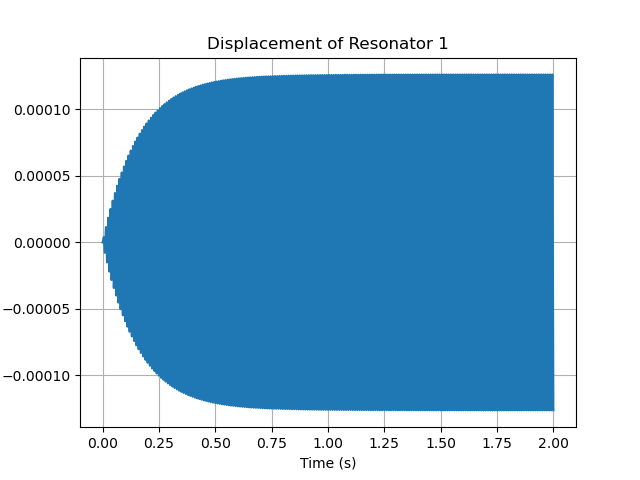

In [9]:
plt.figure()
plt.plot(t, x1)
plt.grid()
plt.title("Displacement of Resonator 1")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.show()

Ok cela fonctionne, on peut donc construire une fonction qui fait la tâche demandée:



In [ ]:
@register_dataclass
@dataclass
class CalculateSteadyStatePowerParams:
    t0: float = 0.0
    t1: float = 2.0
    max_steps: int = 1000000


def calculate_steady_state_power(
    X0,
    ode_params: CoupledLinearResonatorParams,
    calc_params: CalculateSteadyStatePowerParams,
):
    """
    Calculate the steady-state power dissipated by each resonator.

        A tuple containing the steady-state power dissipated by resonator 1 and resonator
    """
    term = ODETerm(coupled_linear_resonator_ode)  # Define the ODE term
    solver = Dopri5()  # Choose the Dormand-Prince 5(4) solver
    t0 = calc_params.t0  # Initial time
    t1 = calc_params.t1  # Final time
    Td = 2 * jnp.pi / ode_params.w0 * ode_params.W  # Driving period
    t2 = t1 + Td

    saveat0 = SaveAt(ts=[t0, t1])  # Specify time points to save the solution
    stepsize_controller = PIDController(rtol=1e-7, atol=1e-7)
    sol0 = diffeqsolve(
        term,
        solver,
        t0=t0,
        t1=t1,
        dt0=0.01,
        y0=X0,
        saveat=saveat0,
        stepsize_controller=stepsize_controller,
        max_steps=calc_params.max_steps,
        args=ode_params,
    )
    X1 = sol0.ys[-1]  # State at time t1
    X1 = X1.at[4:].set(0.0)  # Reset accumulated power to zero
    saveat1 = SaveAt(ts=[t1, t2])  # Specify time points to save the solution
    stepsize_controller = PIDController(rtol=1e-7, atol=1e-7)
    sol1 = diffeqsolve(
        term,
        solver,
        t0=t1,
        t1=t2,
        dt0=0.01,
        y0=X1,
        saveat=saveat1,
        stepsize_controller=stepsize_controller,
        max_steps=calc_params.max_steps,
        args=ode_params,
    )
    X2 = sol1.ys[-1]  # State at time t2
    P = (X2[4:]) / Td  # Average power dissipated over one period
    return P


P = calculate_steady_state_power(
    X0, ode_params, CalculateSteadyStatePowerParams(t0=0.0, t1=2.0)
)
P

Array([0.03978732, 0.03978732], dtype=float64)

On peut donc calculer les puissances en régime établi pour les 2 oscillateurs. 
Faisons maintenant une étude paramétrique avec `vmap`:

In [ ]:
rv = jnp.linspace(0., 2.0, 20)
epsilonv = jnp.linspace(0.0, 2, 20)

vcalc_steady_state_power = vmap(
    vmap(
        calculate_steady_state_power,
        in_axes=(
            None,
            CoupledLinearResonatorParams(
                w0=None,
                Q=None,
                A=None,
                r=0,
                epsilon=None,
                beta=None,
                W=None,
            ),
            None,
        ),
    ),
    in_axes=(
        None,
        CoupledLinearResonatorParams(
             w0=None,
                Q=None,
                A=None,
                r=None,
                epsilon=0,
                beta=None,
                W=None,
        ),
        None,
    ),
)
ode_params2 = CoupledLinearResonatorParams(
    w0 = 200. * jnp.pi,
    Q = 50.,
    A = 1.0,
    r= rv,
    epsilon=epsilonv,
    beta=1.0,
    W=1.0,
)
calc_params2 = CalculateSteadyStatePowerParams(t0=0.0, t1=200.0)
P2 = vcalc_steady_state_power(X0, ode_params2, calc_params2)
P2.shape

In [ ]:
cmap = "jet"
fig = plt.figure(figsize=(12, 6))
ax0 = fig.add_subplot(131)
plt.contourf(K1v, K12v, P2[:, :, 0].T, levels=20, cmap=cmap)
plt.colorbar(label="P1 [W]", orientation="horizontal")
plt.contour(K1v, K12v, P2[:, :, 0].T, levels=20, colors="black", linewidths=0.5)
plt.xlabel("K1")
plt.ylabel("K12")
plt.grid()
ax1 = fig.add_subplot(132)
plt.contourf(K1v, K12v, P2[:, :, 1].T, levels=20, cmap=cmap)
plt.colorbar(label="P2 [W]", orientation="horizontal")
plt.contour(K1v, K12v, P2[:, :, 1].T, levels=20, colors="black", linewidths=0.5)
plt.xlabel("K1")
# plt.ylabel("K2")
plt.grid()
ax1 = fig.add_subplot(133)
plt.contourf(K1v, K12v, P2[:, :, 1].T + P2[:, :, 0].T, levels=20, cmap=cmap)
plt.colorbar(label="P1 + P2 [W]", orientation="horizontal")
plt.contour(
    K1v, K12v, P2[:, :, 1].T + P2[:, :, 0].T, levels=20, colors="black", linewidths=0.5
)
plt.xlabel("K1")
# plt.ylabel("K2")
plt.grid()
plt.show()

C'est beau mais assez étrange. A discuter !

In [ ]:
plt.figure()
plt.plot(K1v, P2[0, :, 0] * 1.0e3)
plt.show()